In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import random
import matplotlib.pyplot as plt

In [ ]:
base_path = "/content/drive/MyDrive/Crop classifier"

In [ ]:
#dataset_path = "RGB_224x224"
dataset_path = os.path.join(base_path, "RGB_224x224")

In [ ]:
# !rsync -ah --info=progress2 "/content/drive/MyDrive/Crop classifier/RGB_224x224/" "/content/RGB_224x224/"
# dataset_path = "/content/RGB_224x224"

In [ ]:
train_dir = os.path.join(dataset_path,"train")

In [ ]:
classes = os.listdir(train_dir)

In [ ]:
len(classes)

141

**Show Sample Images**

In [ ]:
random.sample(classes,5)

['Navy bean plant',
 'Sage plant',
 'Rapeseed (Canola) plant',
 'Swiss chard plant',
 'Apples plant']

In [ ]:
def show_sample_images(num_classes = 4):
    fig,axes = plt.subplots(num_classes,5,figsize=(10,3*num_classes))
    for i , class_name in enumerate(random.sample(classes,num_classes)):
        class_path = os.path.join(train_dir,class_name)
        images = os.listdir(class_path)

        for j in range(5):
            img_path = os.path.join(class_path,images[j])
            img = Image.open(img_path)
            axes[i,j].imshow(img)
            axes[i,j].set_title(class_name)
            axes[i,j].axis("off")
    plt.tight_layout()

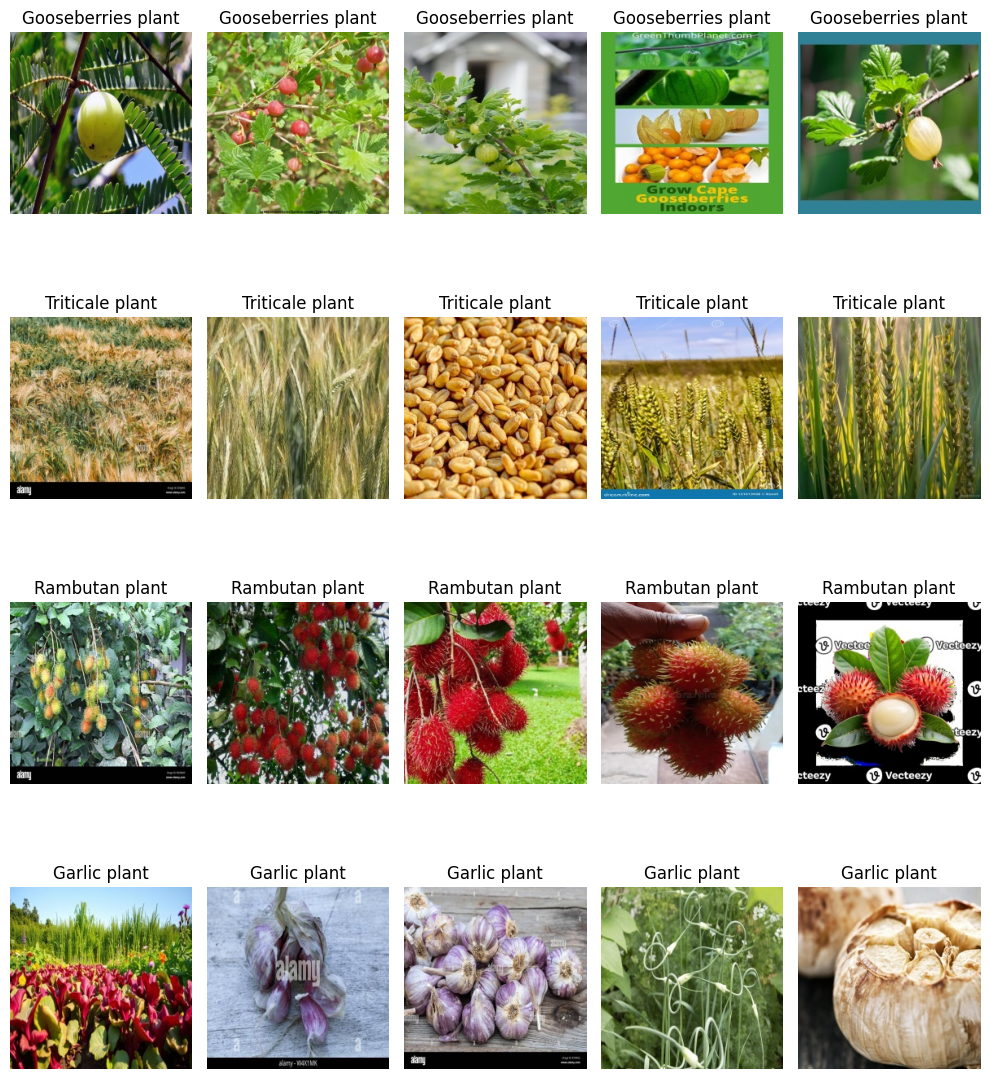

In [ ]:
show_sample_images()

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize([0.485,0.456,0.406],
                     [0.229,0.224,0.225])

])

# Images come in many sizes → resize all to 224×224 (standard for ResNet).
# Convert to tensors (so PyTorch can handle them).
# Normalize colors → makes training more stable.

Datasets and Loaders

In [ ]:
train_dataset = ImageFolder(os.path.join(dataset_path,"train"), transform = transform)
val_dataset = ImageFolder(os.path.join(dataset_path,"val"), transform = transform)
test_dataset = ImageFolder(os.path.join(dataset_path,"test"), transform = transform)

In [ ]:
# train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True,num_workers=8)
# val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)
# test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False,
                          num_workers=2, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False,
                          num_workers=2, pin_memory=True, persistent_workers=True)


In [ ]:
import torchvision.models as models
import torch.nn as nn

In [ ]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

**MODEL**

In [ ]:
model = models.resnet18(pretrained = True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False
# Freezes all pretrained layers → we won’t retrain them, only reuse their “knowledge”.

In [ ]:
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features,num_classes)
# Replaces the final fully connected layer with one that matches our number of crop classes

model = model.to(device)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

#Loss function (CrossEntropyLoss):Measures how wrong the predictions are.
#Optimizer (Adam):Updates weights using gradients from backpropagation.

In [ ]:
# def train_one_epoch(model,loader):
#     model.train()
#     running_loss = 0

#     for images,labels in loader :
#         images,labels = images.to(device) , labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs,labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     return running_loss/len(loader)

if torch.cuda.is_available():
    scaler = torch.amp.GradScaler(device="cuda")
else:
    scaler = None

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        if scaler:  # GPU available
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:  # CPU fallback
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)


In [ ]:
def evaluate(model,loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images , labels in loader :
            images ,labels = images.to(device),labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total


In [ ]:
epochs = 5
for epoch in range(epochs):
    train_loss = train_one_epoch(model,train_loader)
    val_acc = evaluate(model,val_loader)
    print(f"Epoch {epoch+1}, Train Loss : {train_loss:.4f},Val Accuracy : {val_acc : .4f}")

Epoch 1, Train Loss : 3.8585,Val Accuracy :  0.3415
Epoch 2, Train Loss : 2.7583,Val Accuracy :  0.4093
Epoch 3, Train Loss : 2.4119,Val Accuracy :  0.4267
Epoch 4, Train Loss : 2.2163,Val Accuracy :  0.4517
Epoch 5, Train Loss : 2.0924,Val Accuracy :  0.4622


In [34]:
test_acc = evaluate(model,test_loader)

In [ ]:
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return img_tensor * std[:, None, None] + mean[:, None, None]

In [ ]:
def visualise_predictions(model,loader,n=5):
    model.eval()
    images_shown = 0
    class_names = train_dataset.classes

    with torch.no_grad():
        for images , labels in loader :
            images = images.to(device)
            outputs = model(images)
            _,preds = torch.max(outputs,1)

            for i in range(n):
                # img = images[i].cpu().permute(1,2,0).numpy()
                # plt.imshow((img*0.229+ 0.485 ))
                img = denormalize(images[i].cpu()).permute(1,2,0).numpy()
                plt.imshow(img)
                plt.title(f"True : {class_names[labels[i]]},Pred : {class_names[preds[i]]}")
                plt.axis("off")
                plt.show()

                images_shown +=1

                if images_shown>=n:
                    return


In [34]:
visualise_predictions(model,test_loader,5)

In [ ]:
#Saving files

model_data = {
"model_state_dict" : model.state_dict(),
"class_to_idx" : train_dataset.class_to_idx
}


import joblib
joblib.dump(model_data,"crop_classifier_model_gpu.pkl")

['crop_classifier_model_gpu.pkl']

In [ ]:
# This way, .pkl will load anywhere (CPU or GPU)
model_data = {
    "model_state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
    "class_to_idx": train_dataset.class_to_idx
}
import joblib
joblib.dump(model_data, "crop_classifier_model_cpu.pkl")


['crop_classifier_model_cpu.pkl']